In [136]:
#установка необходимых модулей
!pip install shap

In [137]:
#загрузка необходимых библиотек и модулей
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import statistics

from sklearn.model_selection import train_test_split
import catboost as catb

import seaborn as sns

import shap
#загрузка кода визуализации в блокнот
shap.initjs()

%matplotlib inline

# Домашнее задание №7

1. взять любой набор данных для бинарной классификации (можно скачать один из модельных с https://archive.ics.uci.edu/ml/datasets.php)
2. сделать обзорный анализ выбранного датасета
3. сделать feature engineering
4. обучить любой классификатор (какой вам нравится)
5. разобраться с SHAP и построить важности признаков для:
    - всего тестового набора данных (summary_plot - дать интерпретацию)
    - для топ 10%
6. для отдельных наблюдений вывести force_plot и попытаться проинтерпретировать результат


### Решение

**1. Загрузка датасета**

Источник датасета: https://archive.ics.uci.edu/ml/datasets/Caesarian+Section+Classification+Dataset

*Описание датасета*\
Age -- возраст \
Delivery_Number -- номер поступления (1, 2, 3, 4)\
Delivery_Time -- время поступления (0 = своевремено, 1 = преждевремено, 2 = запоздалое)\
Blood_Pressure -- артериальное давление (0 = низкое, 1 = нормальное, 2 = высокое)\
Heart_Problem -- проблемы с сердцем (0 = нет, 1 = да)\
Caesarian -- проведение кесарева сечения (0 = нет, 1 = да)

In [138]:
# заголовки для признаков
_headers = ['Age', 'Delivery_Number', 'Delivery_Time', 'Blood_Pressure', 'Heart_Problem', 'Caesarian']
# загрузка датасета
df = pd.read_csv('caesarian.csv.arff', names=_headers, index_col=None, skiprows=15)
df.head(3)

,Age,Delivery_Number,Delivery_Time,Blood_Pressure,Heart_Problem,Caesarian
0,22,1,0,2,0,0
1,26,2,0,1,0,1
2,26,2,1,1,0,0


**2. Обзорный анализ датасета**

In [139]:
#датасет содержит 80 наблюдений и 5 признаков
df.shape

(80, 6)

In [140]:
#пропусков в данных нет
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80 entries, 0 to 79
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   Age              80 non-null     int64
 1   Delivery_Number  80 non-null     int64
 2   Delivery_Time    80 non-null     int64
 3   Blood_Pressure   80 non-null     int64
 4   Heart_Problem    80 non-null     int64
 5   Caesarian        80 non-null     int64
dtypes: int64(6)
memory usage: 3.9 KB


Типы признаков:
1) вещественные признаки: Age,\
2) категориальные признаки: Delivery_Number, Delivery_Time, Blood_Pressure,\
2) бинарные признаки: Heart_Problem.

Целевая переменная: Caesarian (бинарная).

**3. feature engineering**

In [141]:
# Датасет для feature engineering
select = [x for x in df.columns if (x != "Caesarian")]
X = df.loc[:, select]
X.head(3)

,Age,Delivery_Number,Delivery_Time,Blood_Pressure,Heart_Problem
0,22,1,0,2,0
1,26,2,0,1,0
2,26,2,1,1,0


Feature encoding

In [142]:
#Вычислям медианное значение Age по каждому значению следующих признаков
for feature in ['Delivery_Number','Delivery_Time', 'Blood_Pressure', 'Heart_Problem']:
    d = X.groupby(feature, as_index=False).median()[[feature,'Age']].rename(columns={
    'Age': f'Age encode {feature}'})
    X = X.merge(d, on=feature, how='left')
X.head(3)

,Age,Delivery_Number,Delivery_Time,Blood_Pressure,Heart_Problem,Age encode Delivery_Number,Age encode Delivery_Time,Age encode Blood_Pressure,Age encode Heart_Problem
0,22,1,0,2,0,26.0,28,28.5,26
1,26,2,0,1,0,28.0,28,27.0,26
2,26,2,1,1,0,28.0,27,27.0,26


In [143]:
#Вычислям значение моды по каждому из следующих признаков в зависимости от возраста
for feature in ['Delivery_Number','Delivery_Time', 'Blood_Pressure', 'Heart_Problem']:
    d = X.groupby('Age', as_index=False)[feature].apply(statistics.mode)[['Age',feature]].rename(columns={
    feature: f'{feature} encode Age'})
    X = X.merge(d, on='Age', how='left')
X.head(3)

,Age,Delivery_Number,Delivery_Time,Blood_Pressure,Heart_Problem,Age encode Delivery_Number,Age encode Delivery_Time,Age encode Blood_Pressure,Age encode Heart_Problem,Delivery_Number encode Age,Delivery_Time encode Age,Blood_Pressure encode Age,Heart_Problem encode Age
0,22,1,0,2,0,26.0,28,28.5,26,1,0,2,0
1,26,2,0,1,0,28.0,28,27.0,26,2,1,1,0
2,26,2,1,1,0,28.0,27,27.0,26,2,1,1,0


Target encoding

In [144]:
# target encording для количественного признака Age
for feature in ['Age']:
    t = pd.concat([X,df['Caesarian']], axis=1).\
         groupby(feature, as_index=False)['Caesarian'].apply(statistics.mode)[[feature, 'Caesarian']].\
         rename(columns={'Caesarian': f'Caesarian_encode_{feature}'})
    t = pd.DataFrame(t)
    X = X.merge(t, on=feature, how='left')
X.head(3)

,Age,Delivery_Number,Delivery_Time,Blood_Pressure,Heart_Problem,Age encode Delivery_Number,Age encode Delivery_Time,Age encode Blood_Pressure,Age encode Heart_Problem,Delivery_Number encode Age,Delivery_Time encode Age,Blood_Pressure encode Age,Heart_Problem encode Age,Caesarian_encode_Age
0,22,1,0,2,0,26.0,28,28.5,26,1,0,2,0,0
1,26,2,0,1,0,28.0,28,27.0,26,2,1,1,0,0
2,26,2,1,1,0,28.0,27,27.0,26,2,1,1,0,0


In [145]:
# target encording для категориальных признаков
for feature in ['Delivery_Number', 'Delivery_Time', 'Blood_Pressure', 'Heart_Problem']:
    t = pd.concat([X,df['Caesarian']], axis=1).\
         groupby(feature, as_index=False)['Caesarian'].apply(statistics.mode)[[feature, 'Caesarian']].\
         rename(columns={'Caesarian': f'Caesarian_encode_{feature}'})
    t = pd.DataFrame(t)
    X = X.merge(t, on=feature, how='left')
X.head(3)

,Age,Delivery_Number,Delivery_Time,Blood_Pressure,Heart_Problem,Age encode Delivery_Number,Age encode Delivery_Time,Age encode Blood_Pressure,Age encode Heart_Problem,Delivery_Number encode Age,Delivery_Time encode Age,Blood_Pressure encode Age,Heart_Problem encode Age,Caesarian_encode_Age,Caesarian_encode_Delivery_Number,Caesarian_encode_Delivery_Time,Caesarian_encode_Blood_Pressure,Caesarian_encode_Heart_Problem
0,22,1,0,2,0,26.0,28,28.5,26,1,0,2,0,0,1,1,1,0
1,26,2,0,1,0,28.0,28,27.0,26,2,1,1,0,0,1,1,0,0
2,26,2,1,1,0,28.0,27,27.0,26,2,1,1,0,0,1,0,0,0


In [146]:
#Собираем датасет после преобразования признаков
df = pd.concat([X, df['Caesarian']], axis=1)
df.head(3)

,Age,Delivery_Number,Delivery_Time,Blood_Pressure,Heart_Problem,Age encode Delivery_Number,Age encode Delivery_Time,Age encode Blood_Pressure,Age encode Heart_Problem,Delivery_Number encode Age,Delivery_Time encode Age,Blood_Pressure encode Age,Heart_Problem encode Age,Caesarian_encode_Age,Caesarian_encode_Delivery_Number,Caesarian_encode_Delivery_Time,Caesarian_encode_Blood_Pressure,Caesarian_encode_Heart_Problem,Caesarian
0,22,1,0,2,0,26.0,28,28.5,26,1,0,2,0,0,1,1,1,0,0
1,26,2,0,1,0,28.0,28,27.0,26,2,1,1,0,0,1,1,0,0,1
2,26,2,1,1,0,28.0,27,27.0,26,2,1,1,0,0,1,0,0,0,0


In [147]:
#преобразованный датасет содержит 80 наблюдений и 18 признаков
df.shape

(80, 19)

**4. Обучение бинарного классификатора CatBoostClassifier**

In [148]:
#разделим данные на train/test
X = df.drop(['Caesarian'], axis=1)
y = df['Caesarian']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
print(X_train.shape, X_test.shape)

(60, 18) (20, 18)


In [149]:
#считаем дисбаланс
disbalance = y_train.value_counts()[0] / y_train.value_counts()[1]
disbalance

0.6666666666666666

In [150]:
model_catb = catb.CatBoostClassifier(silent=True, 
                                     random_state=21,
                                     class_weights=[1, disbalance],
                                     eval_metric='F1',
                                     early_stopping_rounds=20,
                                     cat_features=['Delivery_Number', 'Delivery_Time', 'Blood_Pressure', 'Heart_Problem'],
                                     iterations=40,
                                     max_depth=4
                                     )
#обучаем модель
model_catb.fit(X_train, y_train)

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


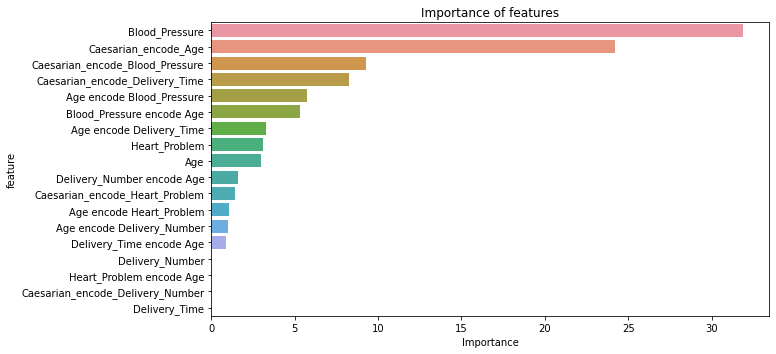

In [151]:
#важность признаков
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (10, len(feature_importances) * 0.3))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

important_features_top = show_feature_importances(X_train.columns, model_catb.feature_importances_, get_top=10)

**5. SHAP**

Так как признаков и наблюдений в датасете мало, проведем интерпретацию предсказаний модели с использованием SHAP на всем тестовой наборе данных и сформируем портрет наиболее предрасположенной к кесареву сечению женщины на основе исходных признаков.

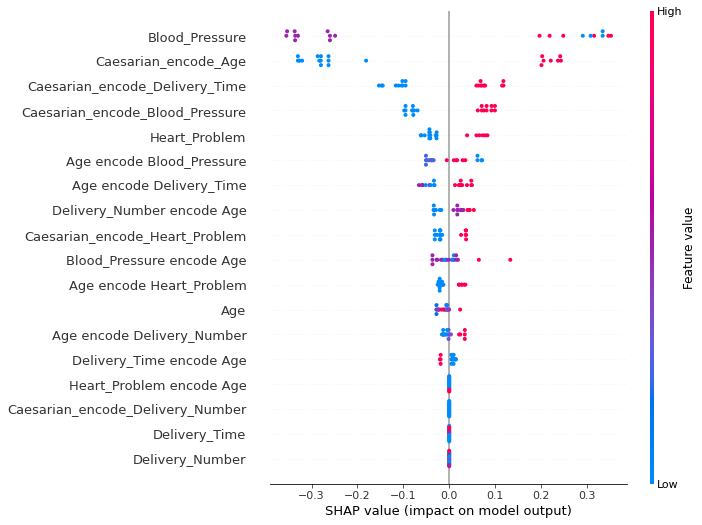

In [152]:
explainer = shap.TreeExplainer(model_catb)
shap_test = explainer.shap_values(X_test)
shap.summary_plot(shap_test, X_test)

Интерпретация:
1. У женщин с нормальным артериальным давлением вероятность кесарева сечения меньше.
2. Если женщина в том возрасте, в котором по статистике роженицам наиболее часто проводят кесарево сечение, то вероятность кесарева сечения у нее выше.
3. Если женщины имеет время поступления, при котором по статистике роженицам наиболее часто проводят кесарево сечение, то вероятность кесарева сечения у нее выше.
4. Если у женщины давление, при котором по статистике роженицам наиболее часто проводят кесарево сечение, то вероятность кесарева сечения у нее выше.
5. Если у женщины есть проблемы с сердцем, то вероятность кесарева сечения выше.
6. Чем выше медианный возраст рожениц с таким же давлением, как у конкретной женщины, тем выше риск кесарева сечения.
7. Чем выше медианное значение возрастов рожениц по времени поступления женщины, тем вероятность кесарева сечения выше.
8. Если женщина в возрасте, при котором по статистике наиболее частый номер поступления рожениц 1, то вероятность кесарева сечения ниже.
9. Если с такими же проблемами с сердцем как у женщины, роженицам наиболее часто проводят кесарево сечение, то и у нее вероятность оперативного вмешательства выше.
10. Если в возрасте женщины роженицы наиболее часто имеют высокое артериальное давление, то вероятность кесарева сечения у нее выше.
11. Чем выше медианное значение возраста рожениц, у которых такие же проблемы с сердцем, как у конкретной женщины, тем выше вероятность проведения ей кесарева сечения.
12. Чем младше женщина, тем вероятность кесарева сечения меньше.
13. Чем выше медианный возраст рожениц по номеру поступления женщины, тем выше у нее вероятность кесарева сечения.
14. Если возраст женщины такой, при котором рождениц по статистике наиболее часто доставляют запоздало, то вероятность кесарева сечения у нее ниже.

Анализ влияния базовых признаков на вероятность проведения кесарева сечения:
1. Чем младше женщина, тем вероятность кесарева сечения меньше.
2. У женщин с нормальным артериальным давлением вероятность кесарева сечения меньше.
3. Если у женщины есть проблемы с сердцем, то вероятность кесарева сечения выше.
**Вывод:** наиболее вероятно проведения кесарева сечения женщине старше 35 лет, которая имеет проблемы с сердцем, не нормальное кровяное давление.

**6. Интерпретация результата для отдельных наблюдений**

Рассмотрим и дадим интерпретацию прогноза модели для 0-го наблюдения X_test (роженице не делали кесарево сечение)

In [153]:
#интерпретация предсказаний модели с помощью SHAP
explainer = shap.TreeExplainer(model_catb)
shap_values = explainer.shap_values(X_test)

# визуализация интерпретации первого предсказания (не делали кесарево сечение)
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test.iloc[0,:])

Интерпретация:
1. Полученное значение (прогноз для первого наблюдения): -0.24.
2. Базовое значение: 0.02852 -- среднее значение, полученное при обучении.
3. Предсказание в сторону класса 1 смещает то, что:\
 -- есть проблемы с сердцем,\
 -- при наличии проблем с сердцем роженицам наиболее часто делают касарево сечение, \
 -- в возрасте женщины роженицам чаще делают кесарево сечение.
   
   Предсказание в сторону класса 0 смещает то, что:\
 -- кровяное давление нормальное,\
 -- с таким кровяным давлением роженицам чаще не делают кесарево сечение,\
 -- при запоздалом поступлении роженицам чаще не делают кесарево сечение.

Рассмотрим и дадим интерпретацию прогноза модели для 5-го наблюдения X_test (роженице сделали кесарево сечение)

In [154]:
# визуализация интерпретации пятого предсказания (сделали кесарево сечение)
shap.force_plot(explainer.expected_value, shap_values[5,:], X_test.iloc[5,:])

Интерпретация:
1. Полученное значение (прогноз для первого наблюдения): 0.75.
2. Базовое значение: 0.02852 -- среднее значение, полученное при обучении.
3. Предсказание в сторону класса 1 смещает то, что:\
 -- кровяное давление низкое,\
 -- в возрасте женщины роженицам чаще делают кесарево сечение,\
 -- при таком кровяном давлении роженицам чаще делают кесарево сечение,\
 -- есть проблемы с сердцем,\
 -- медианный возраст женщин с таким кровяным давлением 26.5.
 
   Предсказание в сторону класса 0 смещает то, что: \
 -- при запоздалом поступлении роженицам чаще не делают кесарево сечение,\
 -- медианный возраст рожениц с таким же номером поступления 26 лет. 